# Import important stuff


In [1]:
# Who does not need math in his life?
import math

# Phases will be returned as floats and we want factions!
from fractions import Fraction

# The infamous numpy module, with C-compiled code for quick maths
import numpy as np

# Braket SDK v1.61.0
# Circuits !
from braket.circuits import Circuit, circuit
# Qubits !
from braket.circuits.qubit_set import QubitSetInput, QubitSet
from braket.circuits.qubit import Qubit

# Devices !
from braket.devices import Device, LocalSimulator   # Local simulator
local_simulator = LocalSimulator()
from braket.aws import AwsDevice    # AWS simulators/QPU

# Devices return results (hopefully !) containing a Counter
from collections import Counter

# Functions are commented with a clear input/output typing to help you
from typing import Any, Dict, List, Optional
# We will choose `a` as random to run Shor's algorithm (1 < a < N)
from random import randint, sample
# If we need to wait for the Device to finish a simulation, better sleep a little
from time import sleep
# For log displays
from datetime import datetime

# Little function that efficiently compute the bit-size of an integer
def bit_size_of(integer_N):
    s = 0
    while integer_N > 0:
        integer_N = integer_N // 2
        s += 1
    return s

# Qiskit produces nice images of quantum circuits
# We want to do them from Braket circuits
from braket.circuits.serialization import IRType
import qiskit.qasm3
def braket_to_qiskit_circuit(braket_circuit, without_measurements = False):
    # Produce QASM3 string
    qasm_str = braket_circuit.to_ir(IRType.OPENQASM).source
    # Split lines
    qasm_str_lines = qasm_str.split('\n')
    # Include the stdgates.inc
    qasm_str_lines.insert(1, 'include "stdgates.inc";')
    # Index of the first measurement
    index_of_first_measure = qasm_str_lines.index("b[0] = measure q[0];")
    
    if without_measurements:
        # Remove instructions relative to classical bits and measures
        qasm_str_lines = qasm_str_lines[:index_of_first_measure]
        qasm_str_lines.remove(f"bit[{braket_circuit.qubit_count}] b;")
    else:
        # Include a barrier to separate measurements
        qasm_str_lines.insert(index_of_first_measure, f'barrier;')
    
    # Regroup lines
    qasm_str = '\n'.join(qasm_str_lines)
    # Replace Braket gate names with std ones
    qasm_str = qasm_str.replace("cphaseshift", "cphase").replace("phaseshift", "phase").replace("cnot", "cx")
    # Create the Qiskit circuit
    return qiskit.qasm3.loads(qasm_str)

# Create the QFT circuit
The Quantum Fourier Transform is the well-known circuit allowing to change a state vector from the computational basis to the Fourier basis.
In Shor's algorithm, we use the modular exponentiation controlled by a register `reg_x`. There is a "phase kickback effect" that will inprint the phase of the modular exponentiation into `reg_x` "written" in the Fourrier basis. We use QFT-dagger to transform that in the computational basis, so that we can measure it.

In [2]:
# Compared to implementations found on the Internet, this one is different because my convention is to
# encode number in little endian
# So for example, if a registry contains 4 qubits q0, q1, q2 and q3:
# 1 => q0=1, q1=0, q2=0, q3=0
# 2 => q0=0, q1=1, q2=0, q3=0
# 4 => q0=0, q1=0, q2=1, q3=0
# 8 => q0=0, q1=0, q2=0, q3=1
# 7 => q0=1, q1=1, q2=1, q3=0
# Most implementation on the Internet use a BigEndian encoding (I'm not sure why) and it changes things for QFT
@circuit.subroutine(register=True)
def qft(
    qubits: QubitSetInput,
    reverse: Optional[bool] = False,
    do_swaps: Optional[bool] = True,
) -> Circuit:
    """
    Construct a circuit object corresponding to the inverse Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the circuit.
    
    Args:
        qubits (QubitSetInput): Qubits on which to apply the inverse Quantum Fourier Transform
        reverse (Optional[bool]): Create a reversed version of this circuit
    Returns:
        Circuit: Circuit object that implements the inverse Quantum Fourier Transform algorithm
    """
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    for k in reversed(range(num_qubits)):
        # First add a Hadamard gate
        qftcirc.h(qubits[k])
    
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in reversed(range(k)):
            angle = 2*math.pi/(2**(1+k-j))
            if reverse:
                angle = -angle
            qftcirc.cphaseshift(qubits[j], qubits[k], angle)
            
    # Then add SWAP gates to reverse the order of the qubits:
    if do_swaps:
        for i in range(math.floor(num_qubits/2)):
            qftcirc.swap(qubits[i], qubits[-i-1])

    # If the reversed Gate is asked, we simply reverse the instructions order
    if reverse:
        qftcirc = Circuit(reversed(qftcirc.instructions))

    return qftcirc

We can display this circuit for an arbitrary number of qubits to see what it looks like:

'qft with 3 qubits:'

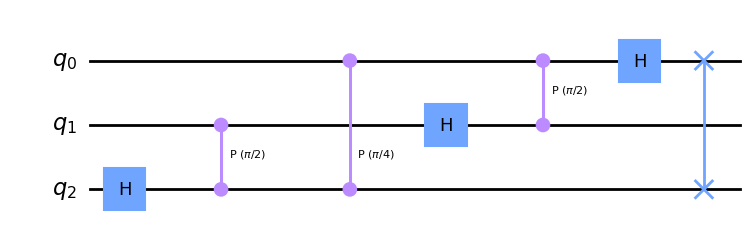

'qft_dagger with 3 qubits:'

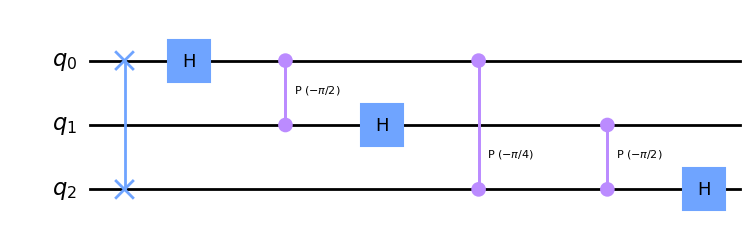

In [26]:
EXAMPLE_QUBIT_COUNT=3
display(f"qft with {EXAMPLE_QUBIT_COUNT} qubits:")
display(braket_to_qiskit_circuit(qft([*range(EXAMPLE_QUBIT_COUNT)]), True).draw('mpl'))
display(f"qft_dagger with {EXAMPLE_QUBIT_COUNT} qubits:")
display(braket_to_qiskit_circuit(qft([*range(EXAMPLE_QUBIT_COUNT)], reverse=True), True).draw('mpl'))

# Create the generic modular exponentiation
Based on this answer: https://quantumcomputing.stackexchange.com/a/14773

Which itself is an interpretation of https://arxiv.org/pdf/quant-ph/9511018.pdf

The principle here is to construct very simple quantum circuits for simple tasks. We begin with a simple 3-qubit circuit for the sum of 2 qubits. Then another 4-qubits circuit for the carry of the 2-qubit addition, then we use those to construct a generic adder, then an adder modulo N, and so on and so forth until we get a circuit able to compute the modular exponantiation of an integer...

As the scientific paper states, this implementation is simple to understand but in now way efficient. It results in a Quantum Circuit with 7n+2 qubits, n being the number of bit required to represent the number N to factor (size_of(N)). For example, 15 is a 4-bit number, so the quantum circuit will have 7*4+2=30 qubits.

This can be brought down to 4n+3 qubit, as in the other notebook, by NOT using any quantum register to encode classical information (such as N, a, etc...) and creating a quantum adder that perform additions in the Fourier space, thus not needing a carry register. Of course, the circuit construction is less intuitive, but well worth your while. See `shors-2-4n+3.ipynb`

## Sum on 3 qubits
In the end, `q_r = q_a + q_b`

In [4]:
@circuit.subroutine(register=True)
def q_sum_3(
    q_a: Qubit, q_b: Qubit, q_r: Qubit,
    reverse: bool = False
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate, taking 3-qubits: a, b and r. r is supposed to be
    initialized in the |0> state. The circuit perform the addition modulo-2 of a and b,
    that is r = a XOR b
    Args:
        q_a (Qubit): First term to add
        q_b (Qubit): Second term to add
        q_r (Qubit): Result of the addition modulo 2 of q_a and q_b (a XOR b)
        reverse (bool): Create a reversed version of this circuit
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    # Instantiate circuit object
    c = Circuit()
    
    # Add the gates
    c.cnot(q_b, q_r)
    c.cnot(q_a, q_r)
    
    # If the reversed Gate is asked, we simply reverse the instructions order
    if reverse:
        c = Circuit(reversed(c.instructions))
    return c


In [5]:
# Test the reversibility

# Create a 2 qubit register
reg = [*range(3)]

# For all the possible values on 2 bits
for test_number in range(2**2):
    c = Circuit()
    # Init the 2 first qubits of the register
    for i in range(2):
        # If the i-th bit in the test_number is 1
        if 2**i & test_number:
            # Flip the corresponding qubit in reg with a not-gate (thus changing it from 0 (the default) to 1)
            c.x(reg[i])

    # Add our circuit, then its inverse
    c.q_sum_3(reg[0], reg[1], reg[2])
    c.q_sum_3(reg[0], reg[1], reg[2], True)

    # Now simulate the circuit 1000 times and retrieve the measures
    measures = local_simulator.run(c, shots=1000).result().measurement_counts.keys()
    # There should only be one result because this circuit should be completly deterministic
    assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
    for measure in measures:
        # Verify the result is expected
        result = int(''.join(reversed(measure)), 2)
        # Verify that we obtain the correct result
        assert test_number == result, f"{test_number} != {result}"


'q_sum_3:'

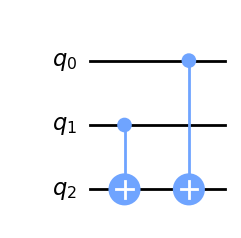

In [6]:

display("q_sum_3:")
display(braket_to_qiskit_circuit(q_sum_3(0, 1, 2), True).draw('mpl'))

## Carry on 3 qubits
In the end, `q_new_c = (q_old_c + q_a + q_b) // 2`. Another way of saying it is that `q_new_c` is 1 if and only if at least 2 of the 3 input registers are 1.

In [7]:
@circuit.subroutine(register=True)
def q_carry_3(
    q_old_c: Qubit, 
    q_a: Qubit, q_b: Qubit,
    q_new_c: Qubit,
    reverse: bool = False
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate, taking 4-qubits: old_c, a, b and new_c. new_c is supposed to be
    initialized in the |0> state. The circuit place the carry of old_c + a + b in new_c.
    Note that it changes the states of old_c, a and b ; therefore in a more global circuit the reverse of
    this one will come handy.
    Args:
        q_old_c (Qubit): First term to add
        q_a (Qubit): Second term to add
        q_b (Qubit): Third term to add
        q_c (Qubit): Carry of the addition modulo 2 of q_old_c, q_a and q_b
        reverse (bool): Create a reversed version of this circuit
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    # Instantiate circuit object
    c = Circuit()
    
    # Add the gates
    c.ccnot(q_a, q_b, q_new_c)
    c.cnot(q_a, q_b)
    c.ccnot(q_old_c, q_b, q_new_c)
    
    # If the reversed Gate is asked, we simply reverse the instructions order
    if reverse:
        c = Circuit(reversed(c.instructions))
    return c


In [8]:
# Test the reversibility

# Create a 4 qubit register
reg = [*range(4)]

# For all the possible values on 3 bits
for test_number in range(2**3):
    c = Circuit()
    # Init the 2 first qubits of the register
    for i in range(3):
        # If the i-th bit in the test_number is 1
        if 2**i & test_number:
            # Flip the corresponding qubit in reg with a not-gate (thus changing it from 0 (the default) to 1)
            c.x(reg[i])

    # Add our circuit, then its inverse
    c.q_carry_3(reg[0], reg[1], reg[2], reg[3])
    c.q_carry_3(reg[0], reg[1], reg[2], reg[3], True)

    # Now simulate the circuit 1000 times and retrieve the measures
    measures = local_simulator.run(c, shots=1000).result().measurement_counts.keys()
    # There should only be one result because this circuit should be completly deterministic
    assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
    for measure in measures:
        # Verify the result is expected
        result = int(''.join(reversed(measure)), 2)
        # Verify that we obtain the correct result
        assert test_number == result, f"{test_number} != {result}"

'q_carry_3:'

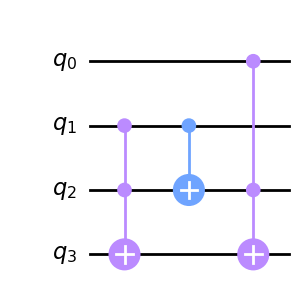

In [9]:

display("q_carry_3:")
display(braket_to_qiskit_circuit(q_carry_3(0, 1, 2, 3), True).draw('mpl'))

## Adder circuit
At the end, `reg_b = reg_a + reg_b`

`reg_c` is reseted to its initial status after being used as the carry register

In [10]:
@circuit.subroutine(register=True)
def q_adder(
    reg_a: QubitSetInput,
    reg_b: QubitSetInput,
    reg_c: QubitSetInput,
    reverse: bool = False
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate, taking 3 registers: reg_a, reg_b and reg_c. reg_a and reg_b respectivly 
    contain integers a and b. reg_c is expected to contain 0 and will be used for carries.
    At the end of the circuit, reg_b contains a + b. Even if integers a and b were initially the same size in bits (which is expected),
    a + b can be 1-bit longer, which is why size(reg_b) = size(reg_a) + 1
    Args:
        reg_a (QubitSetInput): Register of the number a
        reg_b (QubitSetInput): Register of the number b, will contain a + b at the end of the circuit
        reg_c (QubitSetInput): Register storing the carries of the addtion, expected to be |0>
            at the begining of the circuit and will be left unchanged at the end
        reverse (bool): Create a reversed version of this circuit
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    
    # Verify the various register have the right size relative to each others
    assert len(reg_b) == len(reg_a) + 1
    assert len(reg_c) == len(reg_a)
    
    # Instantiate circuit object
    c = Circuit()

    last_index = len(reg_a) - 1

    for i in range(0, last_index):
        c.q_carry_3(reg_c[i], reg_a[i], reg_b[i], reg_c[i + 1])

    c.q_carry_3(reg_c[last_index], reg_a[last_index], reg_b[last_index], reg_b[last_index + 1])
    c.cnot(reg_a[last_index], reg_b[last_index])
    c.q_sum_3(reg_c[last_index], reg_a[last_index], reg_b[last_index])
    
    for i in reversed(range(0, last_index)):
        c.q_carry_3(reg_c[i], reg_a[i], reg_b[i], reg_c[i + 1], True)
        c.q_sum_3(reg_c[i], reg_a[i], reg_b[i])

    if reverse:
        c = Circuit(reversed(c.instructions))

    return c


In [11]:
# Bit-size of integers a and b
n = 3
# Max value of integers a and b
N = 2**n - 1
# Register for integer a, of size n
reg_a = [*range(0, n)]
# Register for integer b, of size n+1 because it will contains a+b in the end, which can be 1 bit longer than a and b
# Register b follows reg_a and therefore is offset by the len of reg_a
reg_b = [*range(len(reg_a) + 0, len(reg_a) + (n + 1))]
# Register c for the carries of the addition, of size n
# Register c follows reg_a and reg_b and therefore is offset by the len of reg_a and reg_b
reg_c = [*range(len(reg_a) + len(reg_b) + 0, len(reg_a) + len(reg_b) + n)]

# For all possible n-bit integers a, verify that our q_adder works as expected
for a in reversed(range(N+1)):
    # For all possible n-bit integers b
    for b in reversed(range(N+1)):
        # New circuit
        c_q_adder = Circuit()
        # Initialize reg_a and reg_b according to the value of a and b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer a is 1
            if 2**i & a:
                # Flip the corresponding qubit in reg_a with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder.x(reg_a[i])
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder.x(reg_b[i])
        # Create the adder using our registers (with reg_a and reg_b initialize by the values of integers a and b, reg_c is unchanged, so it is all 0's)
        c_q_adder.q_adder(reg_a, reg_b, reg_c)
        # Now simulate the circuit 1000 times and retrieve the measures
        measures = local_simulator.run(c_q_adder, shots=1000).result().measurement_counts.keys()
        # There should only be one result because this circuit should be completly deterministic
        assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
        for measure in measures:
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[len(reg_a):len(reg_a) + len(reg_b)])), 2)
            # Verify that we obtain the correct result a + b
            assert a + b == result, f"({a} + {b}) = {a + b} not {result}"

display("q_adder behave as expected")

# For all possible n-bit integers a, verify that our REVERSED-q_adder works as expected
for a in reversed(range(N+1)):
    # For all possible n-bit integers b
    for b in reversed(range(N+1)):
        # New circuit
        c_q_adder = Circuit()
        # Initialize reg_a and reg_b according to the value of a and b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer a is 1
            if 2**i & a:
                # Flip the corresponding qubit in reg_a with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder.x(reg_a[i])
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder.x(reg_b[i])
        # Create the reverse-adder using our registers (with reg_a and reg_b initialize by the values of integers a and b, reg_c is unchanged, so it is all 0's)
        c_q_adder.q_adder(reg_a, reg_b, reg_c, True)
        # Now simulate the circuit 1000 times and retrieve the measures
        measures = local_simulator.run(c_q_adder, shots=1000).result().measurement_counts.keys()
        # There should only be one result because this circuit should be completly deterministic
        assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
        for measure in measures:
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[len(reg_a):len(reg_a) + len(reg_b)])), 2)
            # We expect to obtain the subtraction b-a modulo 2**(n+1) (the size of reg_b)
            expected = (b - a) % 2**(n+1)
            # Verify that we obtain the correct result
            assert expected == result, f"({b} - {a}) = {expected} not {result}"
display("q_adder-dagger behave as expected")

# Test the reversibility

# For all possible n-bit integers a, verify that our q_adder works as expected
for a in reversed(range(N+1)):
    # For all possible n-bit integers b
    for b in reversed(range(N+1)):
        # New circuit
        c = Circuit()
        # Initialize reg_a and reg_b according to the value of a and b
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer a is 1
            if 2**i & a:
                # Flip the corresponding qubit in reg_a with a not-gate (thus changing it from 0 (the default) to 1)
                c.x(reg_a[i])
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c.x(reg_b[i])
        # Create the identity circuit
        c.q_adder(reg_a, reg_b, reg_c)
        c.q_adder(reg_a, reg_b, reg_c, True)
        # Now simulate the circuit 1000 times and retrieve the measures
        measures = local_simulator.run(c, shots=1000).result().measurement_counts.keys()
        # There should only be one result because this circuit should be completly deterministic
        assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
        for measure in measures:
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result_a = int(''.join(reversed(measure[:len(reg_a)])), 2)
            result_b = int(''.join(reversed(measure[len(reg_a):len(reg_a)+len(reg_b)])), 2)
            result_c = int(''.join(reversed(measure[len(reg_a)+len(reg_b):])), 2)
            # Verify that we obtain the correct results
            assert a == result_a, f"{a} != {result_a}"
            assert b == result_b, f"{b} != {result_b}"
            assert 0 == result_c, f"0 != {result_c}"

display("q_adder is inversible as expected")

'q_adder behave as expected'

'q_adder-dagger behave as expected'

'q_adder is inversible as expected'

'q_adder:'

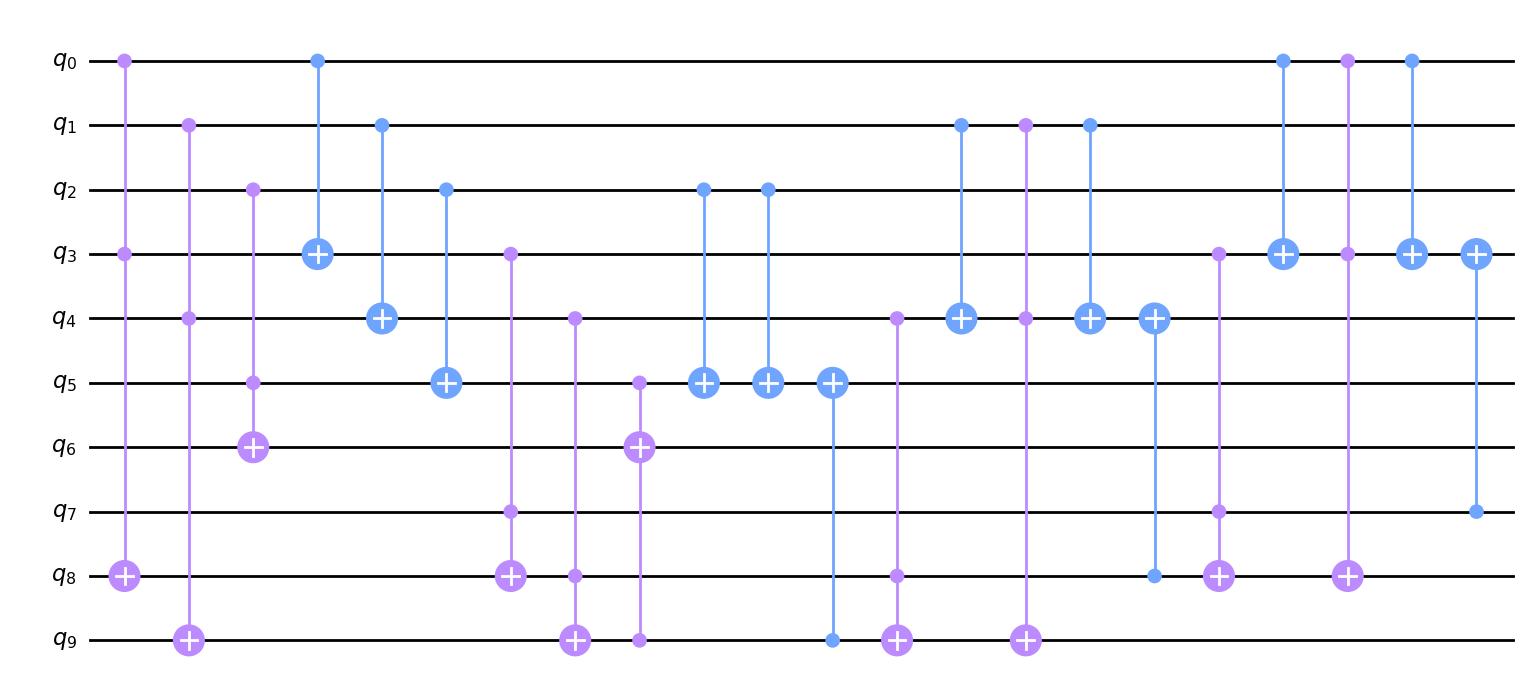

In [12]:
# Bit-size of integers a and b
EXAMPLE_QUBIT_COUNT=3
# Register for integer a, of size n
reg_a = [*range(0, EXAMPLE_QUBIT_COUNT)]
# Register for integer b, of size n+1 because it will contains a+b in the end, which can be 1 bit longer than a and b
# Register b follows reg_a and therefore is offset by the len of reg_a
reg_b = [*range(len(reg_a) + 0, len(reg_a) + (EXAMPLE_QUBIT_COUNT + 1))]
# Register c for the carries of the addition, of size n
# Register c follows reg_a and reg_b and therefore is offset by the len of reg_a and reg_b
reg_c = [*range(len(reg_a) + len(reg_b) + 0, len(reg_a) + len(reg_b) + EXAMPLE_QUBIT_COUNT)]
# Display the resulting circuit
display("q_adder:")
display(braket_to_qiskit_circuit(q_adder(reg_a, reg_b, reg_c), True).draw('mpl'))

## Adder modulo N circuit
At the end, `reg_b = (reg_a + reg_b) % N`

In [13]:
@circuit.subroutine(register=True)
def q_adder_modN(
    N: int,
    reg_a: QubitSetInput,
    reg_b: QubitSetInput,
    reg_c: QubitSetInput,
    reg_N: QubitSetInput,
    q_t: Qubit,
    reverse = False
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate, taking 4 registers: reg_a, reg_b, reg_c and reg_N. reg_a and reg_b respectivly 
    contain integers a and b. reg_c is expected to contain 0 and will be used for carries. reg_N contains the number N used for the modulo.
    At the end of the circuit, reg_b contains (a + b) % N. Even if integers a and b were initially the same size in bits (which is expected),
    a + b can be 1-bit longer, which is why size(reg_b) = size(reg_a) + 1. reg_N is expected to be the same size of reg_a.
    Args:
        N (int): The number N, used to hard-code some part of the circuit
        reg_a (QubitSetInput): Register of the number a
        reg_b (QubitSetInput): Register of the number b, will contain a + b at the end of the circuit
        reg_c (QubitSetInput): Register storing the carries of the addtion, expected to be |0>
            at the begining of the circuit and will be left unchanged at the end
        reg_N (QubitSetInput): Register storing the integer N for the modulo operation. Will be left unchanged at the end
        q_t (Qubit): Control qubit used to verify the sign of a + b - N at some point of the computation. Expected to be |0>
            and will be left unchanged by the computation
        reverse (bool): Create a reversed version of this circuit
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    assert len(reg_b) == len(reg_a) + 1
    assert len(reg_c) == len(reg_a)
    assert len(reg_N) == len(reg_a)
    
    c = Circuit()
    
    # Add reg_a and reg_b
    c.q_adder(reg_a, reg_b, reg_c)
    # Swap a and N
    for i in range(len(reg_a)):
        c.swap(reg_a[i], reg_N[i])
    # Substract N
    c.q_adder(reg_a, reg_b, reg_c, True)
    
    # At this point, reg_b contains a + b - N
    # We want to verify if a + b - N is negative or not.
    # If a + b - N < 0 ; then it means that a + b < N ; therefore a + b = (a + b) % N ; therefore we HAVE to add back N to have the correct result
    # If a + b - N >= 0 ; then it means that a + b >= N ; therefore a + b - N = (a + b) % N ; reg_b contains the correct result, we don't have to correct it.
    # We cannot dynamically change the circuit while running. What we do is that not matter what we will perform an addition reg_b = reg_a + reg_b
    # The trick is to set reg_a to 0 if we don't want to add back N ; or to leave it as it is if we want to add back N.
    # We will control the "set to 0" operation with the qubit q_t.
    # If a + b - N < 0, the most significant bit of reg_b is 1, we want to add back N, so we DON'T want to set reg_a to 0, q_t must stay at 0
    # Else the most significant bit of reg_b is 0, we don't want to add back N, so we want to set reg_a to 0, q_t must be set to 1.
    # 
    # Therefore, we switch the most significant bit of reg_b, use it for a control-NOT operation on q_t, then switch it back.
    # The most significant bit of reg_b is left unchanged by this sequence of operation and
    # q_t will be :
    #    0 if a + b - N < 0
    #    1 if a + b - N >= 0
    c.x(reg_b[-1])
    c.cnot(reg_b[-1], q_t)
    c.x(reg_b[-1])
    
    # The controlled "set reg_a to 0" operation can be hard coded because we KNOW the value of N at circuit construction
    # N will not change and does not depend on our computation: it is constant.
    # Therefore, we know in advance exactly which qubits are 1's and needs to be switched if we want to set reg_a to 0 (which contains N at this point)
    # We hard-code the CNOT gates, with q_t as the control qubit:
    for i in range(len(reg_a)):
        if 2**i & N:
            c.cnot(q_t, reg_a[i])

    # We perform the "add back" operation
    # if reg_a was set to 0, this perform reg_b = reg_b + 0 ; which does not do anything.
    # else reg_a = N, so this perform reg_b = reg_b + N.
    c.q_adder(reg_a, reg_b, reg_c)
    
    # Same controlled "set reg_a to 0" operation, but this time it is as "set reg_a to N" operation as
    # it will be performed only if reg_a was set to 0
    # We simply put back the qubit in place if we had set reg_a to 0 previously
    for i in range(len(reg_a)):
        if 2**i & N:
            c.cnot(q_t, reg_a[i])

    # Swap back a and N
    for i in range(len(reg_a)):
        c.swap(reg_a[i], reg_N[i])
    
    # Now reset q_t to its original value |0>
    # Here is how it works. There is exactly 2 possibilities. At this point, either q_t was set to 1 or it was left to 0.
    #
    # Observe that q_t was set to 1 if and only if a + b - N >= 0 ; so in that case reg_b = a + b - N
    # If we substract a, reg_b = b - N which is bound to be negative: as b is always a value modulo N, it must be strictly less than N, therefore b - N < 0
    # Which means that after substracting a, the most significant qubit of reg_b will be 1, so using it for a CNOT operation on q_t will switch it back to 0.
    #
    # On the other hand, q_t is 0 if and only if a + b - N < 0 ; so in that case reg_b = a + b (because we added back N previously)
    # If we substract a, reg_b = b. As b is a number that can be written we n-bits and size(reg_b) = n + 1 ; the most significant qubit of reg_b must be 0.
    # So using it for a CNOT operation on q_t will do nothing and leave q_t as it is, which is 0.
    #
    # Un-add a with a reverse adder
    c.q_adder(reg_a, reg_b, reg_c, True)
    # CNOT operation on q_t using the most significant qubit of reg_b as the control
    c.cnot(reg_b[-1], q_t)
    # Re-add a
    c.q_adder(reg_a, reg_b, reg_c)
    
    if reverse:
        c = Circuit(reversed(c.instructions))
    return c


In [14]:
# Controls that the circuit is actually performing correctly for all possible value <= 7 MOD 7

# Fix the N
N = 7
# Find the minimum number of bits required to represent N
n = bit_size_of(N)
# Register for integer a, of size n
reg_a = [*range(0, n)]
# Register for integer b, of size n+1 because it will contains a+b at some point, which can be 1 bit longer than a and b
# Register b follows reg_a and therefore is offset by the len of reg_a
reg_b = [*range(len(reg_a) + 0, len(reg_a) + (n + 1))]
# Register c for the carries of the addition, of size n
# Register c follows reg_a and reg_b and therefore is offset by the len of reg_a and reg_b
reg_c = [*range(len(reg_a) + len(reg_b) + 0, len(reg_a) + len(reg_b) + n)]
# Register N to hold the value N, of size n
# Register N follows reg_a, reg_b and reg_c and therefore is offset by the len of reg_a, reg_b and reg_c
reg_N = [*range(len(reg_a) + len(reg_b) + len(reg_c), len(reg_a) + len(reg_b) + len(reg_c) + n)]
# Qubit q_t, which follows all the other register so its number is simply the combined length of the 4 registers
q_t = len(reg_a) + len(reg_b) + len(reg_c) + len(reg_N)


# For all possible integers a smaller than N, verify that our q_adder_modN works as expected
for a in reversed(range(N)):
    # For all possible integers b smaller than N, verify that our q_adder_modN works as expected
    for b in reversed(range(N)):
        # New circuit
        c_q_adder_modN = Circuit()
        # Initialize reg_a, reg_b and reg_N according to the value of a, b and N
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer a is 1
            if 2**i & a:
                # Flip the corresponding qubit in reg_a with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_a[i])
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_b[i])
            # If the i-th bit in the integer N is 1
            if 2**i & N:
                # Flip the corresponding qubit in reg_N with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_N[i])
        # Create the adder mod N using our registers
        # with reg_a, reg_b and reg_N initialized by the values of integers a, b and N, reg_c and q_t are unchanged, so it is all 0's
        c_q_adder_modN.q_adder_modN(N, reg_a, reg_b, reg_c, reg_N, q_t)
        # Now simulate the circuit 1000 times and retrieve the measures
        measures = local_simulator.run(c_q_adder_modN, shots=1000).result().measurement_counts.keys()
        # There should only be one result because this circuit should be completly deterministic
        assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
        for measure in measures:
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[len(reg_a):len(reg_a) + len(reg_b)])), 2)
            # Verify that we obtain the correct result a + b % N
            assert (a + b) % N == result, f"({a} + {b}) % {N} = {(a + b) % N} not {result}"
display("q_adder_modN behave as expected")

# For all possible integers a smaller than N, verify that our REVERSE-q_adder_modN works as expected
for a in reversed(range(N)):
    # For all possible integers b smaller than N, verify that our q_adder_modN works as expected
    for b in reversed(range(N)):
        # New circuit
        c_q_adder_modN = Circuit()
        # Compute (a + b) % N
        b_after = (a + b) % N
        # Initialize reg_a, reg_b and reg_N according to the value of a, b_after and N
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer a is 1
            if 2**i & a:
                # Flip the corresponding qubit in reg_a with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_a[i])
            # If the i-th bit in the integer b_after is 1
            if 2**i & b_after:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_b[i])
            # If the i-th bit in the integer N is 1
            if 2**i & N:
                # Flip the corresponding qubit in reg_N with a not-gate (thus changing it from 0 (the default) to 1)
                c_q_adder_modN.x(reg_N[i])
        # Create the REVERSE adder mod N using our registers
        # with reg_a, reg_b and reg_N initialized by the values of integers a, b and N, reg_c and q_t are unchanged, so it is all 0's
        c_q_adder_modN.q_adder_modN(N, reg_a, reg_b, reg_c, reg_N, q_t, True)
        # Now simulate the circuit 1000 times and retrieve the measures
        measures = local_simulator.run(c_q_adder_modN, shots=1000).result().measurement_counts.keys()
        # There should only be one result because this circuit should be completly deterministic
        assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
        for measure in measures:
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result = int(''.join(reversed(measure[len(reg_a):len(reg_a) + len(reg_b)])), 2)
            # Verify that we obtain the correct result b_after - a % N
            assert (b_after - a) % N == result, f"({b_after} - {a}) % {N} = {(b_after - a) % N} not {result}"
display("q_adder_modN-dagger behave as expected")


# For all possible integers a smaller than N, verify that our q_adder_modN works as expected
for a in reversed(range(N)):
    # For all possible integers b smaller than N, verify that our q_adder_modN works as expected
    for b in reversed(range(N)):
        # New circuit
        c = Circuit()
        # Initialize reg_a, reg_b and reg_N according to the value of a, b_after and N
        # For each bit
        for i in range(n):
            # If the i-th bit in the integer a is 1
            if 2**i & a:
                # Flip the corresponding qubit in reg_a with a not-gate (thus changing it from 0 (the default) to 1)
                c.x(reg_a[i])
            # If the i-th bit in the integer b is 1
            if 2**i & b:
                # Flip the corresponding qubit in reg_b with a not-gate (thus changing it from 0 (the default) to 1)
                c.x(reg_b[i])
            # If the i-th bit in the integer N is 1
            if 2**i & N:
                # Flip the corresponding qubit in reg_N with a not-gate (thus changing it from 0 (the default) to 1)
                c.x(reg_N[i])
        # Create the REVERSE adder mod N using our registers
        # with reg_a, reg_b and reg_N initialized by the values of integers a, b and N, reg_c and q_t are unchanged, so it is all 0's
        c.q_adder_modN(N, reg_a, reg_b, reg_c, reg_N, q_t)
        c.q_adder_modN(N, reg_a, reg_b, reg_c, reg_N, q_t, True)
        # Now simulate the circuit 1000 times and retrieve the measures
        measures = local_simulator.run(c, shots=1000).result().measurement_counts.keys()
        # There should only be one result because this circuit should be completly deterministic
        assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
        for measure in measures:
            # Extract the bits for reg_b only from the resulting measurement, reverse them and convert them to the corresponding int
            result_a = int(''.join(reversed(measure[:len(reg_a)])), 2)
            result_b = int(''.join(reversed(measure[len(reg_a):len(reg_a) + len(reg_b)])), 2)
            result_c = int(''.join(reversed(measure[len(reg_a) + len(reg_b):len(reg_a) + len(reg_b) + len(reg_c)])), 2)
            result_N = int(''.join(reversed(measure[len(reg_a) + len(reg_b) + len(reg_c):len(reg_a) + len(reg_b) + len(reg_c) + len(reg_N)])), 2)
            result_qt = int(''.join(reversed(measure[len(reg_a) + len(reg_b) + len(reg_c) + len(reg_N):])), 2)
            # Verify that we obtain the correct result b_after - a % N
            assert result_a == a, f"{result_a} != {a}"
            assert result_b == b, f"{result_b} != {b}"
            assert result_c == 0, f"{result_c} != 0"
            assert result_N == N, f"{result_N} != {N}"
            assert result_qt == 0, f"{result_qt} != 0"

display("q_adder_modN is inversible as expected")

'q_adder_modN behave as expected'

'q_adder_modN-dagger behave as expected'

'q_adder_modN is inversible as expected'

'q_adder_modN(N=3):'

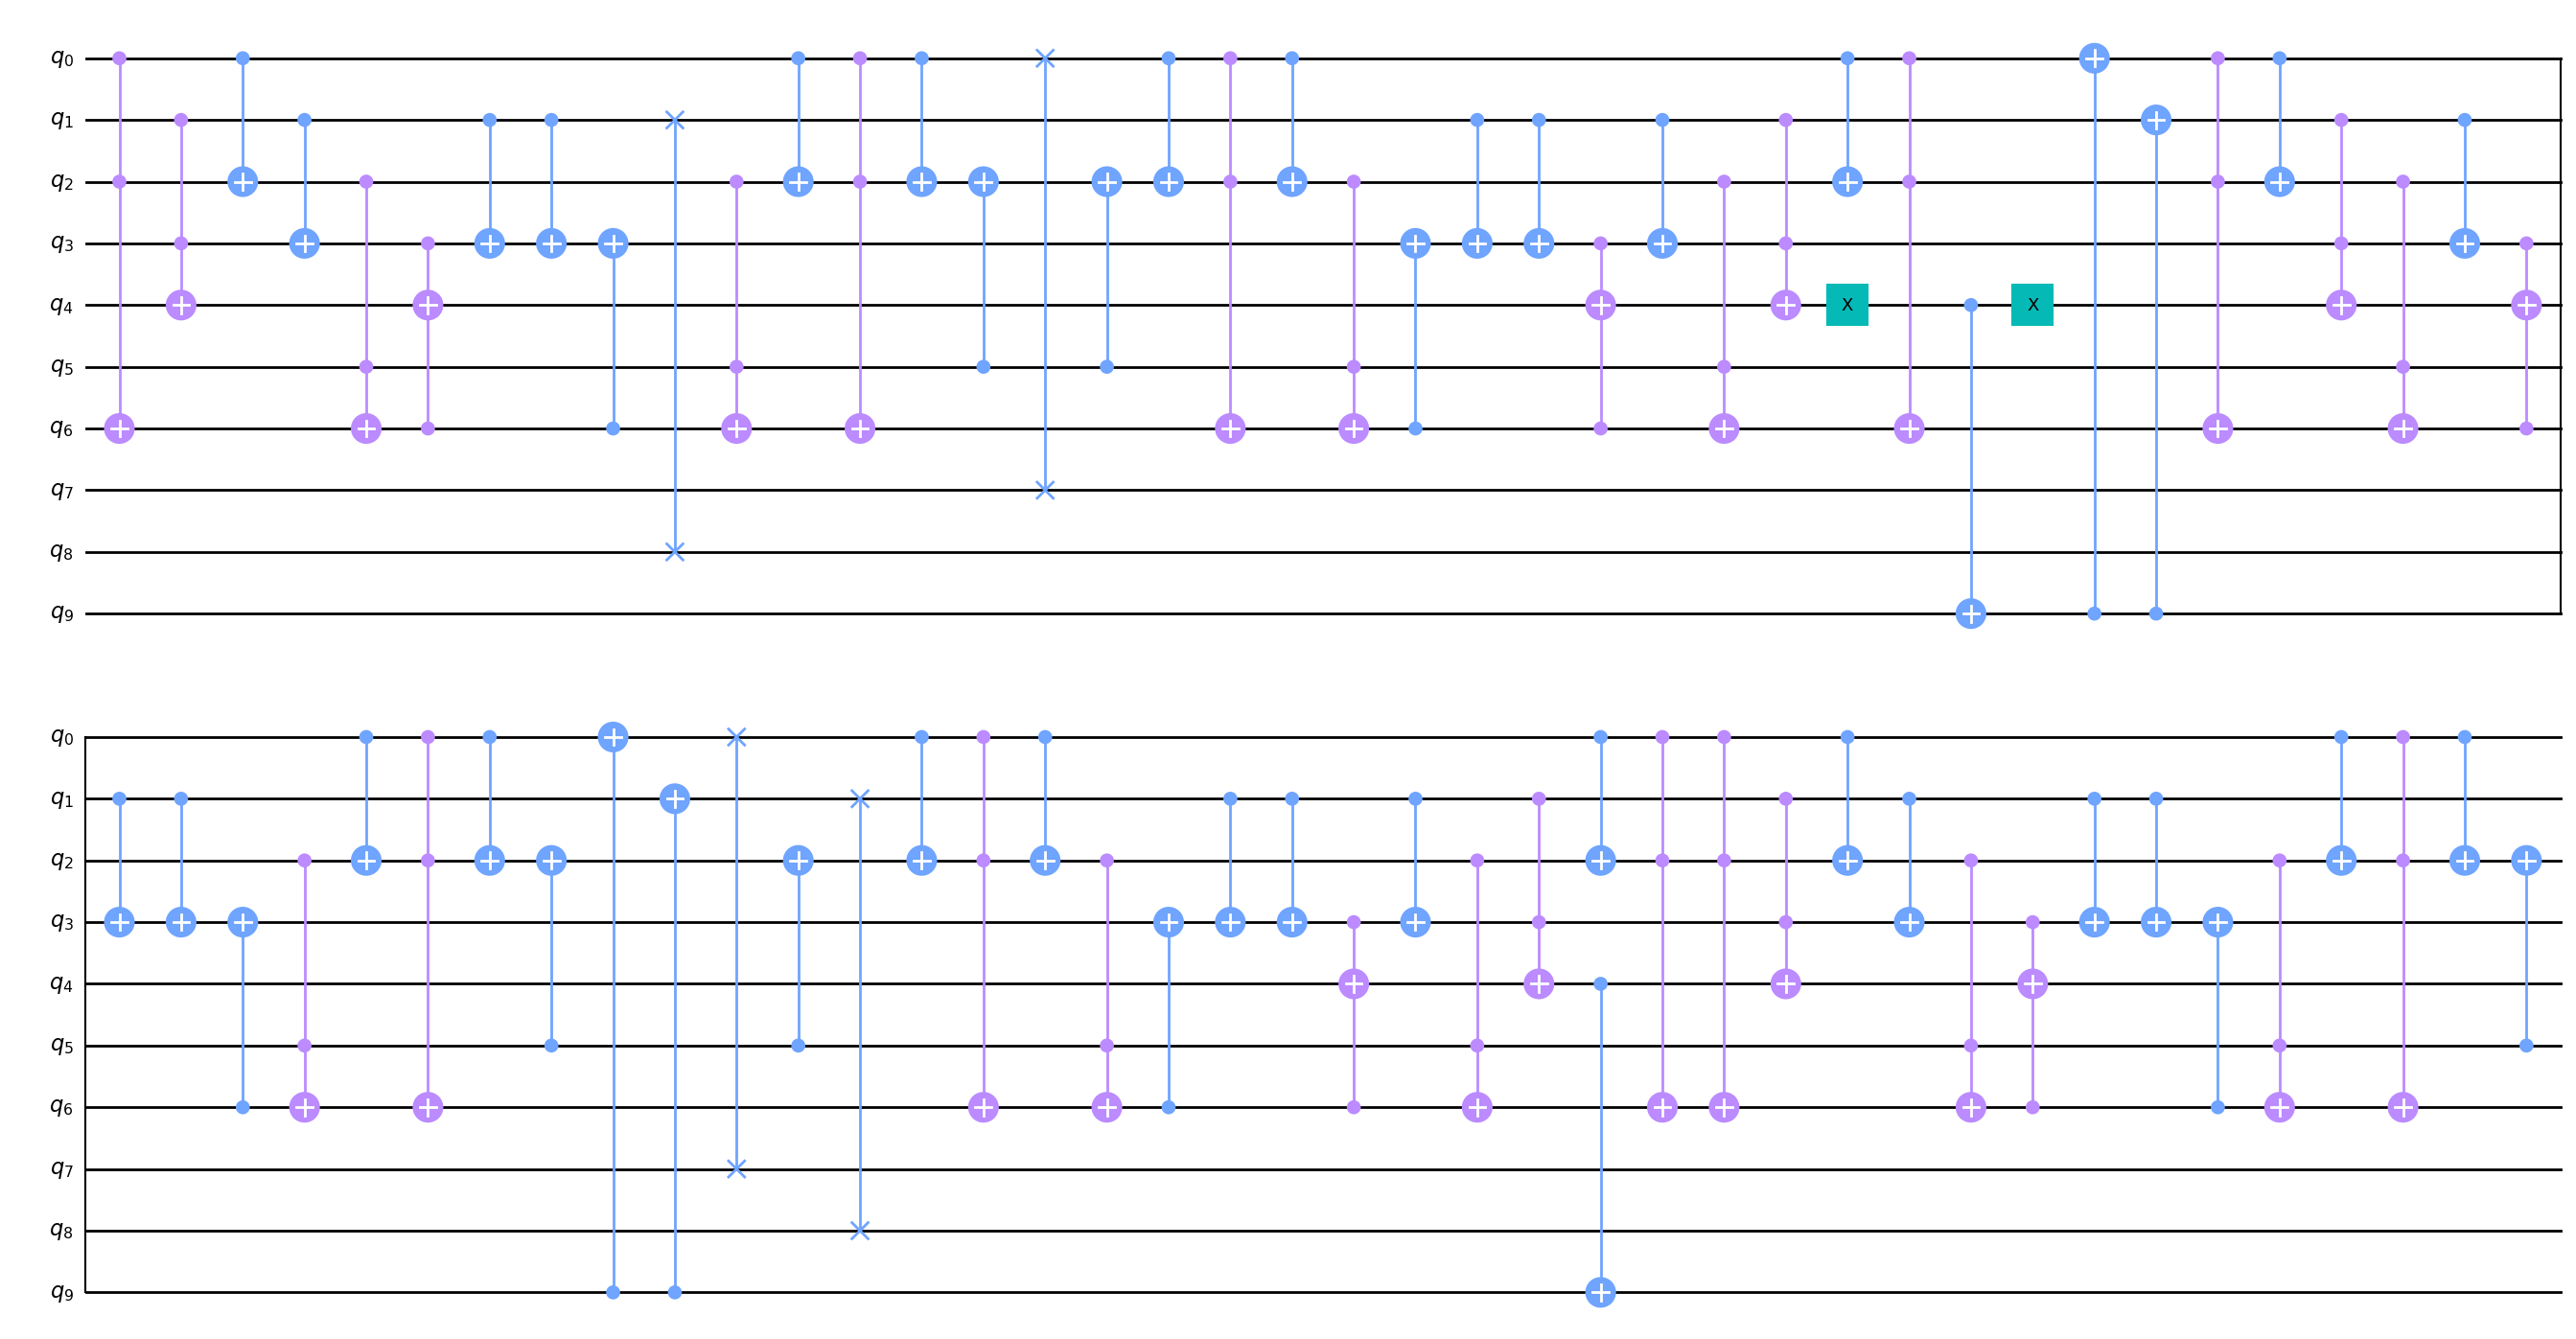

In [15]:
EXAMPLE_N=3
# Find the minimum number of bits required to represent N
n = bit_size_of(EXAMPLE_N)
# Register for integer a, of size n
reg_a = [*range(0, n)]
# Register for integer b, of size n+1 because it will contains a+b at some point, which can be 1 bit longer than a and b
# Register b follows reg_a and therefore is offset by the len of reg_a
reg_b = [*range(len(reg_a) + 0, len(reg_a) + (n + 1))]
# Register c for the carries of the addition, of size n
# Register c follows reg_a and reg_b and therefore is offset by the len of reg_a and reg_b
reg_c = [*range(len(reg_a) + len(reg_b) + 0, len(reg_a) + len(reg_b) + n)]
# Register N to hold the value N, of size n
# Register N follows reg_a, reg_b and reg_c and therefore is offset by the len of reg_a, reg_b and reg_c
reg_N = [*range(len(reg_a) + len(reg_b) + len(reg_c), len(reg_a) + len(reg_b) + len(reg_c) + n)]
# Qubit q_t, which follows all the other register so its number is simply the combined length of the 4 registers
q_t = len(reg_a) + len(reg_b) + len(reg_c) + len(reg_N)

# Display the resulting circuit
display(f"q_adder_modN(N={EXAMPLE_N}):")
display(braket_to_qiskit_circuit(q_adder_modN(EXAMPLE_N, reg_a, reg_b, reg_c, reg_N, q_t), True).draw('mpl', fold=40))

## Controlled Multiplication modulo N circuit

In [16]:
@circuit.subroutine(register=True)
def q_ctrl_mult_modN(
    N: int, m: int,
    q_ctrl: Qubit,
    reg_z: QubitSetInput,
    reg_a: QubitSetInput,
    reg_b: QubitSetInput,
    reg_c: QubitSetInput,
    reg_N: QubitSetInput,
    q_t: Qubit,
    reverse = False
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate, taking 5 registers and 2 individual qubits: q_ctrl is the control qubit that decide if we do
    something or not, reg_z contain the number z we want to multiply by m. We already encountered reg_a, reg_b, reg_c, reg_N and q_t, which will be used as expected
    by the q_adder_modN sub-circuits we will use to construct this one.
    Only q_ctrl, reg_z and reg_N are expected to be non-zero, all other registers are expected to be 0, including reg_b.
    At the end of this circuit, reg_b contains (z * m) % N if q_ctrl is 1 (else it contains z) and is the only register changed by the computation.
    Args:
        N (int): The number N, used to hard-code some part of the circuit, in particular the q_adder_modN
        m (int): The number m, used to hard-code some part of the circuit and in particular to
            create the appropriate number of q_adder_modN to perform (z * m) % N
        q_ctrl (Qubit): Control qubit used that control weither or not we perform the operations. In the grand
            scheme of things, this q_ctrl will be part of a larger register reg_x that will be introduced later.
        reg_z (QubitSetInput): Register of the number z, contains the integer z that we want to multiply,
            will be left unchanged at the end of the computation
        reg_a (QubitSetInput): Register of the number a, expected to be |0> at the begining of the circuit 
            and will be left unchanged at the end of the computation
        reg_b (QubitSetInput): Register of the number b, generally expected to be |0> at the begining of the circuit 
            and will contain (z * m) % N at the end of the computation if q_ctrl is 1, else it will simply contain z.
        reg_c (QubitSetInput): Register storing the carries of the addtion, expected to be |0> at the begining of the circuit 
            and will be left unchanged at the end of the computation
        reg_N (QubitSetInput): Register storing the integer N for the modulo operation
            and will be left unchanged at the end of the computation
        q_t (Qubit): Control qubit used to verify the sign of a + b - N at some point of the q_adder_modN. Expected to be |0>
            and will be left unchanged by the computation
        reverse (bool): Create a reversed version of this circuit
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    assert len(reg_b) == len(reg_a) + 1
    assert len(reg_c) == len(reg_a)
    assert len(reg_N) == len(reg_a)
    assert len(reg_z) == len(reg_a)
    
    c = Circuit()
    # We want to perform a serie of additions modulo N so that, in the end, reg_b = z * m % N
    # Of course, we could simply perform m-time the addition reg_b = reg_b + z, with reg_b initially at 0
    # But that would introduce an additionnal linear complexity O(m). If m is reasonnably large, it would be a problem...
    # But most of all, it is not needed.
    #
    # What we can do is use the following facts:
    # 1/
    # If z is an integer with a binary representation zn...z2z1z0, then
    # z*m = zn*2^n*m + ... + z2*2^2*m + z1*2^1*m + z0*2^0*m
    # It is just a formal way of saying a very obvious thing that you can easily see with a base-10 example:
    # 1873*m = 1000*m + 800*m + 70*m + 3*m = 1*10^3*m + 8*10^2*m + 7*10^1*m + 3*10^0*m
    # 2/
    # And of course: (A + B + C + D) % N = (((A % N + B % N) % N + C % N) % N + D % N) % N ; meaning that 
    # we can apply the modulo N as we go to each individual addition and operand, and obtain exactly the same result
    # as if we were to first perform the complete addition and then apply the modulo.

    # So we use these facts to optimize our circuit. Instead of performing m-time the q_adder_modN, we only need bit_size(z) q_adder_modN
    # For each qubit of the register z
    for j in range(len(reg_z)):
        # Compute the value of (2^j * m) % N
        m2jmodN = (2**j * m) % N
        # Then we will "write" the value of m2jmodN into reg_a in order to add it to reg_b
        # We only want to do this if the j-th bit of z is 1 ; if it is 0, it means we have nothing to add.
        # Also, in any case we only perform these operations if q_ctrl is 1.
        # For each qubit of the register a
        for i in range(len(reg_a)):
            # If the i-th bit if m2jmodN is 1, we want to flip the corresponding qubit of reg_a
            if 2**i & m2jmodN:
                # But only if both q_ctrl and the j-th qubit or reg_z are 1s, so we use a CCNOT operation
                c.ccnot(q_ctrl, reg_z[j], reg_a[i])
        # Then we perform the adder_modN operation so that reg_b = (reg_b + reg_a) % N
        # So if the j-th bit of z is 1, reg_b = (reg_b + m2jmodN) % N
        # else reg_b is unchanged (we add 0)
        c.q_adder_modN(N, reg_a, reg_b, reg_c, reg_N, q_t)
        # Revert reg_a to 0 by doing exactly the same operations used to set it to m2jmodN (in reverse order)
        # For each qubit of the register a
        for i in reversed(range(len(reg_a))):
            # If the i-th bit if m2jmodN is 1, we want to flip the corresponding qubit of reg_a back to 0
            if 2**i & m2jmodN:
                # But only if both q_ctrl and the j-th qubit or reg_z are 1s, so we use a CCNOT operation
                c.ccnot(q_ctrl, reg_z[j], reg_a[i])
    
    # At this point we are finished if q_ctrl is 1. In that case, reg_b = z * m % N which is what we want.
    # But if q_ctrl was 0, then reg_b was left completly untouched and still contains 0
    # We want it to contain z when q_ctrl is 0
    # We flip q_ctrl, so if it was 0 it is now 1
    c.x(q_ctrl)
    # We perform CCNOT operations to flip qubits of reg_b corresponding to 1s in reg_z
    # Essentialy copying whatever reg_z contains is reg_b, but only if q_ctrl is now 1 (meaning it was 0 at the begining of the computation)
    for j in range(len(reg_z)):
        c.ccnot(q_ctrl, reg_z[j], reg_b[j])
    # We flip back q_ctrl, returning it to whatever value it had a the begining of the computation
    c.x(q_ctrl)
    
    if reverse:
        c = Circuit(reversed(c.instructions))
    return c


In [17]:
# Test the reversibility

n = 2
N = 2**n-1
q_ctrl = 0
reg_z = [*range(1, 1 + n)]
reg_a = [*range(1 + len(reg_z) + 0, 1 + len(reg_z) + n)]
reg_b = [*range(1 + len(reg_z) + len(reg_a) + 0, 1 + len(reg_z) + len(reg_a) + n + 1)]
reg_c = [*range(1 + len(reg_z) + len(reg_a) + len(reg_b) + 0, 1 + len(reg_z) + len(reg_a) + len(reg_b) + n)]
reg_N = [*range(1 + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + 0, 1 + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + n)]
q_t = 1 + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + len(reg_N)



# For q_ctlt
for ctlt in range(2):
    # For all the possible values on 2 bits
    for z in range(2**n):
        c = Circuit()
        # Init the 2 first qubits of the register
        for i in range(n):
            if 2**i & z:
                c.x(reg_z[i])
            if 2**i & N:
                c.x(reg_N[i])
        if ctlt > 0:
            c.x(q_ctrl)

        # Add our circuit, then its inverse
        c.q_ctrl_mult_modN(N, 5, q_ctrl, reg_z, reg_a, reg_b, reg_c, reg_N, q_t)
        c.q_ctrl_mult_modN(N, 5, q_ctrl, reg_z, reg_a, reg_b, reg_c, reg_N, q_t, True)
        
        # Now simulate the circuit 1000 times and retrieve the measures
        measures = local_simulator.run(c, shots=1000).result().measurement_counts.keys()
        # There should only be one result because this circuit should be completly deterministic
        assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
        for measure in measures:
            # Verify the result is expected
            result_ctl = int(''.join(reversed(measure[0])), 2)
            result_z = int(''.join(reversed(measure[1:1+len(reg_z)])), 2)
            result_a = int(''.join(reversed(measure[1+len(reg_z):1+len(reg_z)+len(reg_a)])), 2)
            result_b = int(''.join(reversed(measure[1+len(reg_z)+len(reg_a):1+len(reg_z)+len(reg_a)+len(reg_b)])), 2)
            result_c = int(''.join(reversed(measure[1+len(reg_z)+len(reg_a)+len(reg_b):1+len(reg_z)+len(reg_a)+len(reg_b)+len(reg_c)])), 2)
            result_N = int(''.join(reversed(measure[1+len(reg_z)+len(reg_a)+len(reg_b)+len(reg_c):1+len(reg_z)+len(reg_a)+len(reg_b)+len(reg_c)+len(reg_N)])), 2)
            result_t = int(''.join(reversed(measure[1+len(reg_z)+len(reg_a)+len(reg_b)+len(reg_c)+len(reg_N):])), 2)
            # Verify that we obtain the correct result
            assert result_ctl == ctlt, f"{result_ctl} != {ctlt}"
            assert result_z == z, f"{result_z} != {z}"
            assert result_a == 0, f"{result_a} != 0"
            assert result_b == 0, f"{result_b} != 0"
            assert result_c == 0, f"{result_c} != 0"
            assert result_N == N, f"{result_N} != {N}"
            assert result_t == 0, f"{result_t} != 0"
display("q_ctrl_mult_modN is inversible as expected")

'q_ctrl_mult_modN is inversible as expected'

## Modular Exponentiation circuit
At the begining, `reg_z = 1` and in the end `reg_z = y^x mod N`

All the other registers are returned back to their original value, which is 0 expect for `reg_N = N` and `reg_x = x`

In [18]:
@circuit.subroutine(register=True)
def modular_exponentiation_ymodN(
    N: int, y: int,
    reg_x: QubitSetInput,
    reg_z: QubitSetInput,
    reg_a: QubitSetInput,
    reg_b: QubitSetInput,
    reg_c: QubitSetInput,
    reg_N: QubitSetInput,
    q_t: Qubit
) -> Circuit:
    """
    Construct a circuit object, that will become our generic Gate, taking 6 registers and 1 individual qubits: reg_x contains the number x,
    reg_z contains initialy 1. We already encountered reg_a, reg_b, reg_c, reg_N and q_t, which will be used as expected
    by the q_adder_modN sub-circuits composing the q_ctrl_mult_modN sub-circuit that we will use to construct this one.
    Only reg_x, reg_z and reg_N are expected to be non-zero, all other registers are expected to be 0.
    At the end of this circuit, reg_z contains (y^x) % N and is the only register changed by the computation.
    Args:
        N (int): The number N, used to hard-code some part of the circuit, in particular the q_adder_modN
        y (int): The number y that we elevate to power x (contained in reg_x), used to hard-code some part
            of the circuit
        reg_x (QubitSetInput): Register of the number x, contains the integer x that is the power at which
            we want to elevate y and will be left unchanged at the end of the computation
        reg_z (QubitSetInput): Register of the number z, contains 1 initially and y^x at the end of the computation
        reg_a (QubitSetInput): Register of the number a, expected to be |0> at the begining of the circuit 
            and will be left unchanged at the end of the computation
        reg_b (QubitSetInput): Register of the number b, expected to be |0> at the begining of the circuit 
            and will be left unchanged at the end of the computation
        reg_c (QubitSetInput): Register storing the carries of the addtion, expected to be |0> at the begining of the circuit 
            and will be left unchanged at the end of the computation
        reg_N (QubitSetInput): Register storing the integer N for the modulo operation
            and will be left unchanged at the end of the computation
        q_t (Qubit): Control qubit used to verify the sign of a + b - N at some point of the q_adder_modN. Expected to be |0>
            and will be left unchanged by the computation
        reverse (bool): Create a reversed version of this circuit
    Returns:
        Circuit: Resulting circuit that can be used as a Gate in a more complex circuit
    """
    assert len(reg_b) == len(reg_a) + 1
    assert len(reg_c) == len(reg_a)
    assert len(reg_N) == len(reg_a)
    assert len(reg_z) == len(reg_a)
    # No assertion is requiered for reg_x. Its length should be greater than 0, else this whole thing does not make any sense as the circuit will simply be empty
    assert len(reg_x) > 0
    
    c = Circuit()

    # We want to compute y^x % N, that is the modular exponentiation of y to the power of x.
    # Then again, we could simply multiply reg_z (which is 1) by y x-time, but we will do better
    # If x is a binary number xn...x2x1x0, then:
    # y^x = y^(xn*2^n + ... + x2*2^2 + x1*2^1 + x0*2^0)
    # And we know that y^(a + b) = y^a * y^b ; so
    # y^x = y^(xn*2^n) *  ... * y^(x2*2^2) * y^(x1*2^1) * y^(x0*2^0)
    # Therefore the exponantiation can be translated into a serie of multiplication:
    # Starting from the initial value 1, we multiply successively by y^(xn*2^n), which is y^(2^n) if xn is 1, and 1 if xn = 0
    #
    # It should also be noted that (A * B) % N = ((A % N) * (B % N)) % N, therefore we can apply the modulo as we go for each operand and multiplication
    # without changing the final result

    # In the following loop, every operation is controlled by the i-th qubit of reg_x
    # I explain what's going on assuming this i-th qubit is 1
    # If it happens to be 0, the whole iteration does absolutly nothing so there is nothing to explain
    # For each qubit index of the register x
    for i in range(len(reg_x)):
        # Compute m = y^(2^i)
        m = y**(2**i)
        # Performed a ctrl_mult_modN by m, controlled by the i-th qubit of x.
        # Essentially we multiply by y^(2^i) if xi is 1, or we do nothing if xi is 0
        c.q_ctrl_mult_modN(N, m, reg_x[i], reg_z, reg_a, reg_b, reg_c, reg_N, q_t)
        # At this point, if xi is 1, reg_b contains (m * z) % N
        # If xi is 1, we swap the content of reg_z and reg_b
        # We do that with a controled-swap operation for each qubit of reg_z, controlled by xi
        for j in range(len(reg_z)):
            c.cswap(reg_x[i], reg_z[j], reg_b[j])
        # If xi is 1, reg_z and reg_b are now inversed so we essentially saved the result (m * z) % N that was in reg_b into reg_z
        # leaving reg_b with the initial value of reg_z from the previous iteration (or 1 if it is the first iteration)
        # The goal here is to revert b to 0 so it is usable for the next iteration (the next q_ctrl_mult_modN)
        # To do that we compute modular_inverse_of_m as the modular inverse of m modulo N
        # By definition, (m * modular_inverse_of_m) % N = 1
        modular_inverse_of_m = pow(m, -1, N)
        # We use this modular_inverse_of_m to perform the reverse ctrl_mult_modN
        c.q_ctrl_mult_modN(N, modular_inverse_of_m, reg_x[i], reg_z, reg_a, reg_b, reg_c, reg_N, q_t, True)
        # Why does it work?
        # For each iteration (assuming the i-th qubit of reg_x is 1 and we do something), here is what happens
        # Initially we have:
        #   reg_z = z
        #   reg_b = 0
        # After performing the q_ctrl_mult_modN multiplying by m:
        #   reg_z = z
        #   reg_b = (z * m) % N
        # After swaping the registers z and b:
        #   reg_z = (z * m) % N
        #   reg_b = z
        # We recognize that this is the situation we would have IF we had applied a q_ctrl_mult_modN using modular_inverse_of_m instead of m,
        # because by definition:
        # (((z * m) % N) * modular_inverse_of_m) % N = (z * (m * modular_inverse_of_m % N)) % N = (z * 1) % N = z
        # Therefore performing reverse-q_ctrl_mult_modN with modular_inverse_of_m will set back reg_b to 0 (and left reg_z untouched, as usual)
    
    return c

In [19]:
# Controls that the circuit is actually performing correctly for some possible values MOD N

# Choose N
# Carreful, the qubit count Q = 6n+2
# And the complexity of simulating Quantum circuits is O(2^Q)
# It goes up very, very quickly
# Chosing N = 15 means n=4 and Q=26 qubits which means hours for EACH test loop iteration
# With N = 3, n=2, Q=14, which should take few seconds
N = 3
MAX_TESTS=5
# The base size n of the registers is the minimum number of bits required to represent N
n = bit_size_of(N)
# The register x can technically be any size we want, but for this test we will take a 2-sized register
reg_x = [*range(2)]
# Register for integer z, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_z = [*range(len(reg_x) + 0, len(reg_x) + n)]
# Register for integer a, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_a = [*range(len(reg_x) + len(reg_z) + 0, len(reg_x) + len(reg_z) + n)]
# Register for integer b, of size n + 1 because at some point it must hold a+b, which can be 1-bit longer than a and b
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_b = [*range(len(reg_x) + len(reg_z) + len(reg_a) + 0, len(reg_x) + len(reg_z) + len(reg_a) + n + 1)]
# Register for integer c, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_c = [*range(len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + 0, len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + n)]
# Register for integer N, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_N = [*range(len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + 0, len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + n)]
# Qubit q_t, which follows all the other registers so its number is simply the combined length of the 6 registers
q_t = len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + len(reg_N)

# Test y^x mod N for various random values of x and y
# Generate all the values of y so that y is prime with N, GCD(y,N)=1
all_ys = [y for y in range(2, N) if math.gcd(y,N) == 1]
# Multiply that with the possible value for x, taken between 1 and N included
possible_tests = [(y, x) for x in range(2**len(reg_x)) for y in all_ys]
display(f"There are {len(possible_tests)} possible tests, taking at most {MAX_TESTS} of them at random")
tests = sample(possible_tests, min(len(possible_tests), MAX_TESTS))
# Perform at most MAX_TESTS tests
test_number=0
for y, x in tests:
    test_number+=1
    display(f"Test #{test_number} building Modular exponentiation for: ({y}^{x}) % {N}")
    # Create the circuit
    c_modular_exponentiation_ymodN = Circuit()
    # Set reg_z = 1
    c_modular_exponentiation_ymodN.x(reg_z[0])
    # Set reg_x = x, using the usual method
    for i in range(n):
        # If the i-th bit in the integer x is 1
        if 2**i & x:
            # Flip the corresponding qubit in reg_x with a not-gate (thus changing it from 0 (the default) to 1)
            c_modular_exponentiation_ymodN.x(reg_x[i])
        # If the i-th bit in the integer N is 1
        if 2**i & N:
            # Flip the corresponding qubit in reg_N with a not-gate (thus changing it from 0 (the default) to 1)
            c_modular_exponentiation_ymodN.x(reg_N[i])
    # Create the modular exponentiation
    c_modular_exponentiation_ymodN.modular_exponentiation_ymodN(N, y, reg_x, reg_z, reg_a, reg_b, reg_c, reg_N, q_t)
    display(f"Running 1000 shots...")
    # Simulates 1000 shots
    measures = local_simulator.run(c_modular_exponentiation_ymodN, shots=1000).result().measurement_counts.keys()
    # There should only be one result because this circuit should be completly deterministic
    assert len(measures) == 1, f"Expected only one result, got {len(measures)}: {measures}"
    for measure in measures:
        display(f"measure={measure}")
        # Extract from the measurement the value of reg_z
        result = int(''.join(reversed(measure[len(reg_x):len(reg_x) + len(reg_z)])), 2)
        display(f"({y}^{x}) % {N} = {result}")
        assert (y**x) % N == result, f"({y}^{x}) % {N} = {(y**x) % N} not {result}"
    display("")

'There are 4 possible tests, taking at most 5 of them at random'

'Test #1 building Modular exponentiation for: (2^1) % 3'

'Running 1000 shots...'

'measure=10010000000110'

'(2^1) % 3 = 2'

''

'Test #2 building Modular exponentiation for: (2^0) % 3'

'Running 1000 shots...'

'measure=00100000000110'

'(2^0) % 3 = 1'

''

'Test #3 building Modular exponentiation for: (2^2) % 3'

'Running 1000 shots...'

'measure=01100000000110'

'(2^2) % 3 = 1'

''

'Test #4 building Modular exponentiation for: (2^3) % 3'

'Running 1000 shots...'

'measure=11010000000110'

'(2^3) % 3 = 2'

''

In [ ]:
EXAMPLE_N=21
EXAMPLE_Y=5
# The base size n of the registers is the minimum number of bits required to represent N
n = bit_size_of(EXAMPLE_N)
# The register x can technically be any size we want, but for this test we will take a n-sized register
reg_x = [*range(n)]
# Register for integer z, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_z = [*range(len(reg_x) + 0, len(reg_x) + n)]
# Register for integer a, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_a = [*range(len(reg_x) + len(reg_z) + 0, len(reg_x) + len(reg_z) + n)]
# Register for integer b, of size n + 1 because at some point it must hold a+b, which can be 1-bit longer than a and b
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_b = [*range(len(reg_x) + len(reg_z) + len(reg_a) + 0, len(reg_x) + len(reg_z) + len(reg_a) + n + 1)]
# Register for integer c, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_c = [*range(len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + 0, len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + n)]
# Register for integer N, of size n
# It follows the previous registers and therefore is offset by their cumulated lenght
reg_N = [*range(len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + 0, len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + n)]
# Qubit q_t, which follows all the other registers so its number is simply the combined length of the 6 registers
q_t = len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + len(reg_N)
display(f"modular_exponentiation_ymodN(N={EXAMPLE_N}):")
display(braket_to_qiskit_circuit(modular_exponentiation_ymodN(EXAMPLE_N, EXAMPLE_Y, reg_x, reg_z, reg_a, reg_b, reg_c, reg_N, q_t), True).draw('mpl', fold=800, scale=0.6))

# Create the Shor's circuit for a, N

In [21]:
def shors_algorithm(reg_x_size: int, integer_N: int, integer_a: int) -> Circuit:
    """
    Creates the circuit for Shor's algorithm.
      1) Setup auxiliary registers and apply modular exponentiation function
      2) Apply inverse_QFT on counting qubits
    Args:
        reg_x_size (int) : The size of the register reg_x
        integer_N (int) : The integer N to be factored
        integer_a (int) : Any integer 'a' that satisfies 1 < a < N and gcd(a, N) = 1.
    Returns:
        Circuit: Circuit object that implements the Shor's algorithm
    """

    # validate the inputs
    if integer_N < 1 or integer_N % 2 == 0:
        raise ValueError("The input N needs to be an odd integer greater than 1.")
    if integer_a <= 1 or integer_a >= integer_N or math.gcd(integer_a, integer_N) != 1:
        raise ValueError('The integer "a" needs to satisfy 1 < a < N and gcd(a, N) = 1.')

    # calculate n, the number of qubits needed to store N
    n = bit_size_of(integer_N)

    # The register x can technically be any size we want,
    # but in order to obtain sufficient precision for recovering the order of integer_a, we need x to be at least of size 2n+1
    # 
    # integer_a is part of ZN-star, which are the numbers a in {0, 1, ..., N-1} so that gcd(a, N) = 1,
    # so there must exist r, such that integer_a^r = 1 % N ; r is called the order of integer_a
    # We want to retrieve it because it can allow us to factor N, given some additionnal conditions (see further)
    reg_x = [*range(reg_x_size)]
    # Register for integer z, of size n
    # It follows the previous registers and therefore is offset by their cumulated lenght
    reg_z = [*range(len(reg_x) + 0, len(reg_x) + n)]
    # Register for integer a, of size n
    # It follows the previous registers and therefore is offset by their cumulated lenght
    reg_a = [*range(len(reg_x) + len(reg_z) + 0, len(reg_x) + len(reg_z) + n)]
    # Register for integer b, of size n + 1 because at some point it must hold a+b, which can be 1-bit longer than a and b
    # It follows the previous registers and therefore is offset by their cumulated lenght
    reg_b = [*range(len(reg_x) + len(reg_z) + len(reg_a) + 0, len(reg_x) + len(reg_z) + len(reg_a) + n + 1)]
    # Register for integer c, of size n
    # It follows the previous registers and therefore is offset by their cumulated lenght
    reg_c = [*range(len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + 0, len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + n)]
    # Register for integer N, of size n
    # It follows the previous registers and therefore is offset by their cumulated lenght
    reg_N = [*range(len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + 0, len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + n)]
    # Qubit q_t, which follows all the other registers so its number is simply the combined length of the 6 registers
    q_t = len(reg_x) + len(reg_z) + len(reg_a) + len(reg_b) + len(reg_c) + len(reg_N)
    

    # Create a circuit
    shors_circuit = Circuit()

    # Initialize registers
    # All qubits in register reg_x are put in superposition by Hadamar
    # Essentially it can be intuited as making the circuit compute a^x % N for every possible value of x simultaneously
    # Which is the basic advantage of quantum computing, and the central one for Shor's algorithm
    shors_circuit.h(reg_x)
    
    # Register z is initialized to |1>
    shors_circuit.x(reg_z[0])

    # Register N is initialized to |N>
    for i in range(len(reg_N)):
        if 2**i & integer_N:
            shors_circuit.x(reg_N[i])

    # We apply the modular exponentiation a^x ; with x being in superposition
    shors_circuit.modular_exponentiation_ymodN(integer_N, integer_a, reg_x, reg_z, reg_a, reg_b, reg_c, reg_N, q_t)
    # This will kickback the phase of the multiplication by a into x, thus allowing us to retrieve an estimation of this phase
    # Apply inverse QFT on x to retrieve an estimation of the phase
    shors_circuit.qft(reg_x, reverse=True)
    # Now reg_x contains |y> with y/2^size_of(x) = j/r for some unknown j. Recall that r is the order of integer_a modulo N, which is what we are looking for
    # For more details, you need to explore very precisely how Shor's algorythm works. It's not easy.
    # But the number theory connecting r to the factors of N is pretty easy to understand.

    return shors_circuit


# Create a bunch of helper functions

Like a function to run a `circuit` on a `device`, computing the values for `j/r` and trying to recover `r`, and so on and so forth

In [22]:
def run_shors_circuit(
    circuit: Circuit,
    device: Device,
    shots: Optional[int] = 1000,
) -> Dict[str, int]:
    """
    Function to run Shor's algorithm and return measurement counts.
    Args:
        circuit (Circuit): Shor's algorithm circuit
        device (Device): Braket device backend
        shots (Optional[int]) : Number of measurement shots (default is 1000).
            0 shots results in no measurement.
    Returns:
        Dict[str, Any]: measurements and results from running Shors's algorithm
    """

    task = device.run(circuit, shots=shots)

    while task.state() != 'COMPLETED':
        sleep(5)
        
    result = task.result()

    measurement_counts = result.measurement_counts
    measurement_counts = {
        key: measurement_counts[key]
        for key in sorted(
            list(measurement_counts.keys()),
            key=lambda o:measurement_counts[o],
            reverse=True
        )
    }

    return measurement_counts

def split_registers(
    results: Dict[str, int],
    reg_x_size: int,
    n: int,
) -> List[Dict[str, Any]]:
    """
    Function to postprocess dictionary returned by run_shors_algorithm
        and recover the content of each register
    Args:
        results (Dict[str, int]): Measurement produced by run_shors_algorithm
        reg_x_size (int): the number of qubits of reg_x
        n (int) : the number of qubits of the other registers (except reg_b that we know will have size n+1)
    Returns:
        Dict[int, Dict[str, str]] : 
    """
    result_splitted = [
        {
            'reg_x': key[:reg_x_size],
            'reg_z': key[reg_x_size:reg_x_size+n],
            'reg_a': key[reg_x_size+n:reg_x_size+2*n],
            'reg_b': key[reg_x_size+2*n:reg_x_size+3*n+1],
            'reg_c': key[reg_x_size+3*n+1:reg_x_size+4*n+1],
            'reg_N': key[reg_x_size+4*n+1:reg_x_size+5*n+1],
            'q_t': key[reg_x_size+5*n+1:],
            'count': count
        }    
        for key, count in results.items()
    ]
    
    return result_splitted

def get_phases(reg_x_counts: Dict[str, int]) -> List[float]:
    """
    Get phase estimate from measurement_counts using reg_x qubits
    Args:
        reg_x_counts (Dict[str, int]) : reg_x values with the number of time they occured
    Returns:
        List[float] : Phase estimates, ordered by likelihood
    """
    
    # Reg_x all has the same size
    k_sizes = [len(k) for k in reg_x_counts.keys()]
    assert min(k_sizes) == max(k_sizes)

    phase_precision = 2**min(k_sizes)
    # Each phase estimate is reg_x / 2^reg_x_size
    phases_decimals = [
        (int(''.join(reversed(item)), 2) / phase_precision, reg_x_counts[item])
        for item in sorted(
            list(reg_x_counts.keys()),
            key=lambda o:reg_x_counts[o],
            reverse=True
        )
    ]
    display(f"[{datetime.now()}] phases_decimals={phases_decimals}")

    return phases_decimals

def get_factors_from_results(
    splitted_results: List[Dict[str, Any]],
    integer_N: int,
    integer_a: int,
) -> List[int]:
    """
    Function to postprocess dictionary returned by run_shors_algorithm
        and pretty print results
    Args:
        splitted_results (List[Dict[str, Any]]): Measurement produced by run_shors_algorithm and post-processed
        reg_x_size (int): the number of qubits of reg_x
        integer_N (int) : The integer to be factored
        integer_a (int) : Any integer that satisfies 1 < a < N and gcd(a, N) = 1.
        verbose (bool) : If True, prints aggregate results (default is False)
    Returns:
        Dict[str, Any]: Factors of the integer N
    """

    # Agglomerate reg_x
    reg_x_counts = {}
    for splitted_result in splitted_results:
        k = splitted_result['reg_x']
        reg_x_counts[k] = reg_x_counts.get(k, 0) + splitted_result['count']
    
    # get phases
    phases_decimals = get_phases(reg_x_counts)
    # r values
    r_values = {}
    for phase, count in phases_decimals:
        # Each phase yield by the Shor algorithm is phase = j/r ; with j an unknown random value and r the number we are looking for (order of a modulo N)
        # We find the best fraction u/v that approximate the phase using the continued fraction algorithm
        # There is good chances that u/v = j/r ; but it could happen that j and r share factors so in that case u != j and v != r.
        #
        # For example, imagine the correct r is r = 4.
        # If we happen to retrieve the phase for a value j=2, then we have phase = 0.5 and the continued fraction algorithm
        # will yield 1/2. We will register 2 as our r candidate, which is wrong.
        # On the other hand, if we happen to retrieve the phase for a value j=3, then we have phase = 0.75 and the continued fraction algorithm will
        # yield 3/4. We will then register 4 as our r candidate, which is right.
        # It also would work if we retrieve the phase for j=1
        # If we are unlucky and retrieve phase = 0 (for j=0), we do not learn anything because r can have any value in that case: 0 / r = 0, no matter the value of r.
        r = (Fraction(phase).limit_denominator(integer_N)).denominator
        # Accumulate the counts
        r_values[r] = r_values.get(r, 0) + count
    r_values_list = [
        r
        for r in sorted(
            list(r_values.keys()),
            key=lambda o:r_values[o],
            reverse=True
        )
    ]
    
    factors = []
    for r in r_values_list:
        display(f"[{datetime.now()}] r = {r} (count={r_values[r]})")
        if integer_a**r % integer_N != 1:
            display(f"[{datetime.now()}] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered")
            continue
        if r % 2 != 0:
            display(f"[{datetime.now()}] r is odd :'( Skipping to the next r candidate discovered")
            continue
        f = [
            math.gcd(integer_a ** (r // 2) - 1, integer_N),
            math.gcd(integer_a ** (r // 2) + 1, integer_N),
        ]
        display(f"[{datetime.now()}] factors discovered with this r: {f}")
        factors.append(f[0])
        factors.append(f[1])
    # Create a set of unique factors
    factors_set = set(factors)
    # Discard trivial factors
    factors_set.discard(1)
    factors_set.discard(integer_N)
    # Retrun what we are left with
    return list(factors_set)

def run_shors_algo(integer_N: int, device: Device) -> tuple[int, int]:
    """
    Find the factors of integer_N using device to run the Quantum Circuit
    Args:
        integer_N (int) : The integer to be factored
        device (Device): Braket device backend
    Returns:
        (int, int): returns p and q such as p * q = N
    """
    # Find a random a such as 1 < a < N and a is coprime with N (meaning that a belong in the set ZN-star)
    integer_a = randint(2, integer_N - 1)
    display(f"[{datetime.now()}] a = {integer_a}")
    
    # If a is not co-prime with N, it means that a is a factor of either p or q because N = p * q with p and q being primes
    # therefore we already won!
    # Of course, in real life with log2(N)>1024, there is absolutely NO CHANCE to stubble on the solution like that
    gcd_aN = math.gcd(integer_a, integer_N)
    if gcd_aN != 1:
        # We cannot believe our luck, we found either p or q
        p = gcd_aN
        q = integer_N//p
        display(f"[{datetime.now()}] How lucky !! {integer_N} = {p} * {q}")
        return (p, q)
    
    # This security is only do-able if N is small
    # It is not an official part of Shor's procedure for fartorization
    # Nonetheless, around 50% of the a you choose will be worthless
    # So with small N, we verify which a are usefull and wich ones are not in order to avoid useless simulations
    if integer_N < 512:
        # Because the simulation is expensive, we will cheat and eliminate values of a that we KNOW cannot work
        # as we are using small integers for demonstration, we can of course trivially compute all the possible outcomes
        ZNstar = [a for a in range(2, integer_N) if math.gcd(a, integer_N) == 1]
        excluded_a_order_odd = []
        excluded_a_trivial_factors = []
        for a in ZNstar:
            # Find the order of a modulo N
            r = 1
            while a**r % integer_N != 1:
                r += 1
            # If r is not even, it will be unusable
            if r % 2 != 0:
                excluded_a_order_odd.append(a)
                continue
            # If r is even, it can happen that it yields only trivial factors
            factors = [
                math.gcd(a**(r // 2) - 1, integer_N),
                math.gcd(a**(r // 2) + 1, integer_N),
            ]
            factors_set = set(factors)
            # Discard trivial factors
            factors_set.discard(1)
            factors_set.discard(integer_N)
            if len(factors_set) == 0:
                excluded_a_trivial_factors.append(a)

        display(f"[{datetime.now()}] For N={integer_N}, ZNstar={ZNstar}")
        display(f"[{datetime.now()}] For N={integer_N}, values of a in ZNstar that cannot work because their order is odd: {excluded_a_order_odd}")
        display(f"[{datetime.now()}] For N={integer_N}, values of a in ZNstar that cannot work because their order yield trivial factors: {excluded_a_trivial_factors}")
        display(f"[{datetime.now()}] For N={integer_N}, values of a that will work: {[a for a in ZNstar if a not in excluded_a_order_odd and a not in excluded_a_trivial_factors]}")

        if integer_a in excluded_a_order_odd:
            display(f"[{datetime.now()}] Discarding a={integer_a} because we know it will be a waste of time. Its order is odd. Try again!")
            return None
        if integer_a in excluded_a_trivial_factors:
            display(f"[{datetime.now()}] Discarding a={integer_a} because we know it will be a waste of time. Its order yields only trivial factors. Try again!")
            return None

    # Create the circuit
    # reg_x_size will be the 2*n+1, with n the minimum number of bits requiered to encode N
    n = bit_size_of(integer_N)
    reg_x_size = n * 2
    shors_circuit = shors_algorithm(reg_x_size, integer_N, integer_a)
    display(f"[{datetime.now()}] circuit_qubit_count = {shors_circuit.qubit_count}")
    display(f"[{datetime.now()}] circuit_depth = {shors_circuit.depth}")

    # If the circuit is too big, don't try to run it
    if shors_circuit.qubit_count >= 31:
        display(f"[{datetime.now()}] Qubit count is too high for a simulation")
        return None

    # Run the circuit
    results = run_shors_circuit(shors_circuit, device, 1000)
    display(f"[{datetime.now()}] results_from_shor = {results}")
    splitted_results = split_registers(results, reg_x_size, n)
    display(f"[{datetime.now()}] splitted_results_from_shor = {splitted_results}")
    # Go see comments in this fonction to better grasp the principle of Shor algo
    factors = get_factors_from_results(splitted_results, integer_N, integer_a)
    display(f"[{datetime.now()}] factors_from_shor = {factors}")
    if len(factors) == 2:
        p, q = factors
    elif len(factors) == 1:
        p = factors[0]
        q = integer_N//p
    else:
        display(f"[{datetime.now()}] Failed to found factors, try again!")
        return None
    
    display(f"[{datetime.now()}] {integer_N} = {p} * {q}")
    return (p, q)

# Generate a list of possible N to factor

In [23]:
# Maximum bitsize of N
# The circuit will have 7n+2 qubits so 4 is the limit of what is classically computable with modest resources
MAX_SIZE_OF_N = 4

# Find all primes up to 1000
primes = []
for p in range(3, 1000, 2):
    p_is_prime = True
    sqrt_p = int(math.sqrt(p)) + 1
    for q in primes:
        if q > sqrt_p:
            break
        if p % q == 0:
            p_is_prime = False
            break
    if p_is_prime:
        primes.append(p)

# Find the upper bound of N so that its bit-size stays under or equal MAX_SIZE_OF_N
max_N=2**MAX_SIZE_OF_N-1
# Get all the N you could try to factor by multiplying 2 primes and taking all the results under max_N (and that are not squares)
possible_N = sorted(list(set([p * q for p in primes for q in primes if p != q and p * q <= max_N])))

print(possible_N)

[15]


# Run Shor's algorithm on LocalBackend

It will cost nothing to do so and you can reasonnably do it for N = 15 if you reduce the size of x to n instead of 2n. You will get less impressive results of course, and it will still take hours on a laptop.

If you want to try to factor bigger numbers, you need a really beefy computer or a super-computer.

In [24]:
# Factor 15 on LocalSimulator
N = 15
# run_shors_algo(N, local_simulator)

# Run Shor's algorithm on an AWS simulator

It will COST $0.075/minute to do so and you can do it for N so that size_of(N) <= 4 (which means a circuit of 30 qubits max). Simulating a 30qubits circuit on SV1 take ~15minutes.

I'm not aware of an affordable solution allowing to compute Shor for bigger N with this unoptimized algorithm.

In [25]:
import os
os.environ["AWS_ACCESS_KEY_ID"]=""
os.environ["AWS_SECRET_ACCESS_KEY"]=""
os.environ["AWS_SESSION_TOKEN"]=""
os.environ["AWS_REGION"]="us-east-1"

sv1_simulator = AwsDevice('arn:aws:braket:::device/quantum-simulator/amazon/sv1')

# Factor 15 on AWS SV1 simulator
N = 15
run_shors_algo(N, sv1_simulator)

'[2023-11-16 10:05:01.362675] a = 4'

'[2023-11-16 10:05:01.363894] For N=15, ZNstar=[2, 4, 7, 8, 11, 13, 14]'

'[2023-11-16 10:05:01.364902] For N=15, values of a in ZNstar that cannot work because their order is odd: []'

'[2023-11-16 10:05:01.365900] For N=15, values of a in ZNstar that cannot work because their order yield trivial factors: [14]'

'[2023-11-16 10:05:01.366895] For N=15, values of a that will work: [2, 4, 7, 8, 11, 13]'

'[2023-11-16 10:05:03.408028] circuit_qubit_count = 30'

'[2023-11-16 10:05:03.408953] circuit_depth = 7886'

"[2023-11-16 10:20:02.512553] results_from_shor = {'000000000010000000000000011110': 270, '000000010010000000000000011110': 258, '000000011000000000000000011110': 243, '000000001000000000000000011110': 229}"

"[2023-11-16 10:20:02.514543] splitted_results_from_shor = [{'reg_x': '00000000', 'reg_z': '0010', 'reg_a': '0000', 'reg_b': '00000', 'reg_c': '0000', 'reg_N': '1111', 'q_t': '0', 'count': 270}, {'reg_x': '00000001', 'reg_z': '0010', 'reg_a': '0000', 'reg_b': '00000', 'reg_c': '0000', 'reg_N': '1111', 'q_t': '0', 'count': 258}, {'reg_x': '00000001', 'reg_z': '1000', 'reg_a': '0000', 'reg_b': '00000', 'reg_c': '0000', 'reg_N': '1111', 'q_t': '0', 'count': 243}, {'reg_x': '00000000', 'reg_z': '1000', 'reg_a': '0000', 'reg_b': '00000', 'reg_c': '0000', 'reg_N': '1111', 'q_t': '0', 'count': 229}]"

'[2023-11-16 10:20:02.515325] phases_decimals=[(0.5, 501), (0.0, 499)]'

'[2023-11-16 10:20:02.517331] r = 2 (count=501)'

'[2023-11-16 10:20:02.518326] factors discovered with this r: [3, 5]'

'[2023-11-16 10:20:02.519322] r = 1 (count=499)'

"[2023-11-16 10:20:02.520320] a**r % N != 1. r is not the order of a modulo N :'( Skipping to the next r candidate discovered"

'[2023-11-16 10:20:02.521316] factors_from_shor = [3, 5]'

'[2023-11-16 10:20:02.522313] 15 = 3 * 5'

(3, 5)